# Disease Predicton From Medical Data : Heart Stroke Dataset

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Load and Preprocess Data

In [57]:
file_path = '/Volumes/Personal/ML_Code Alpha/Disease-Prediction-from-Medical-Data/healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values in the 'bmi' column
data['bmi'].fillna(data['bmi'].median(), inplace=True)

print("Basic Information about the Dataset:")
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())


Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

First few rows of the dataset:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Mal

# Visualize Data

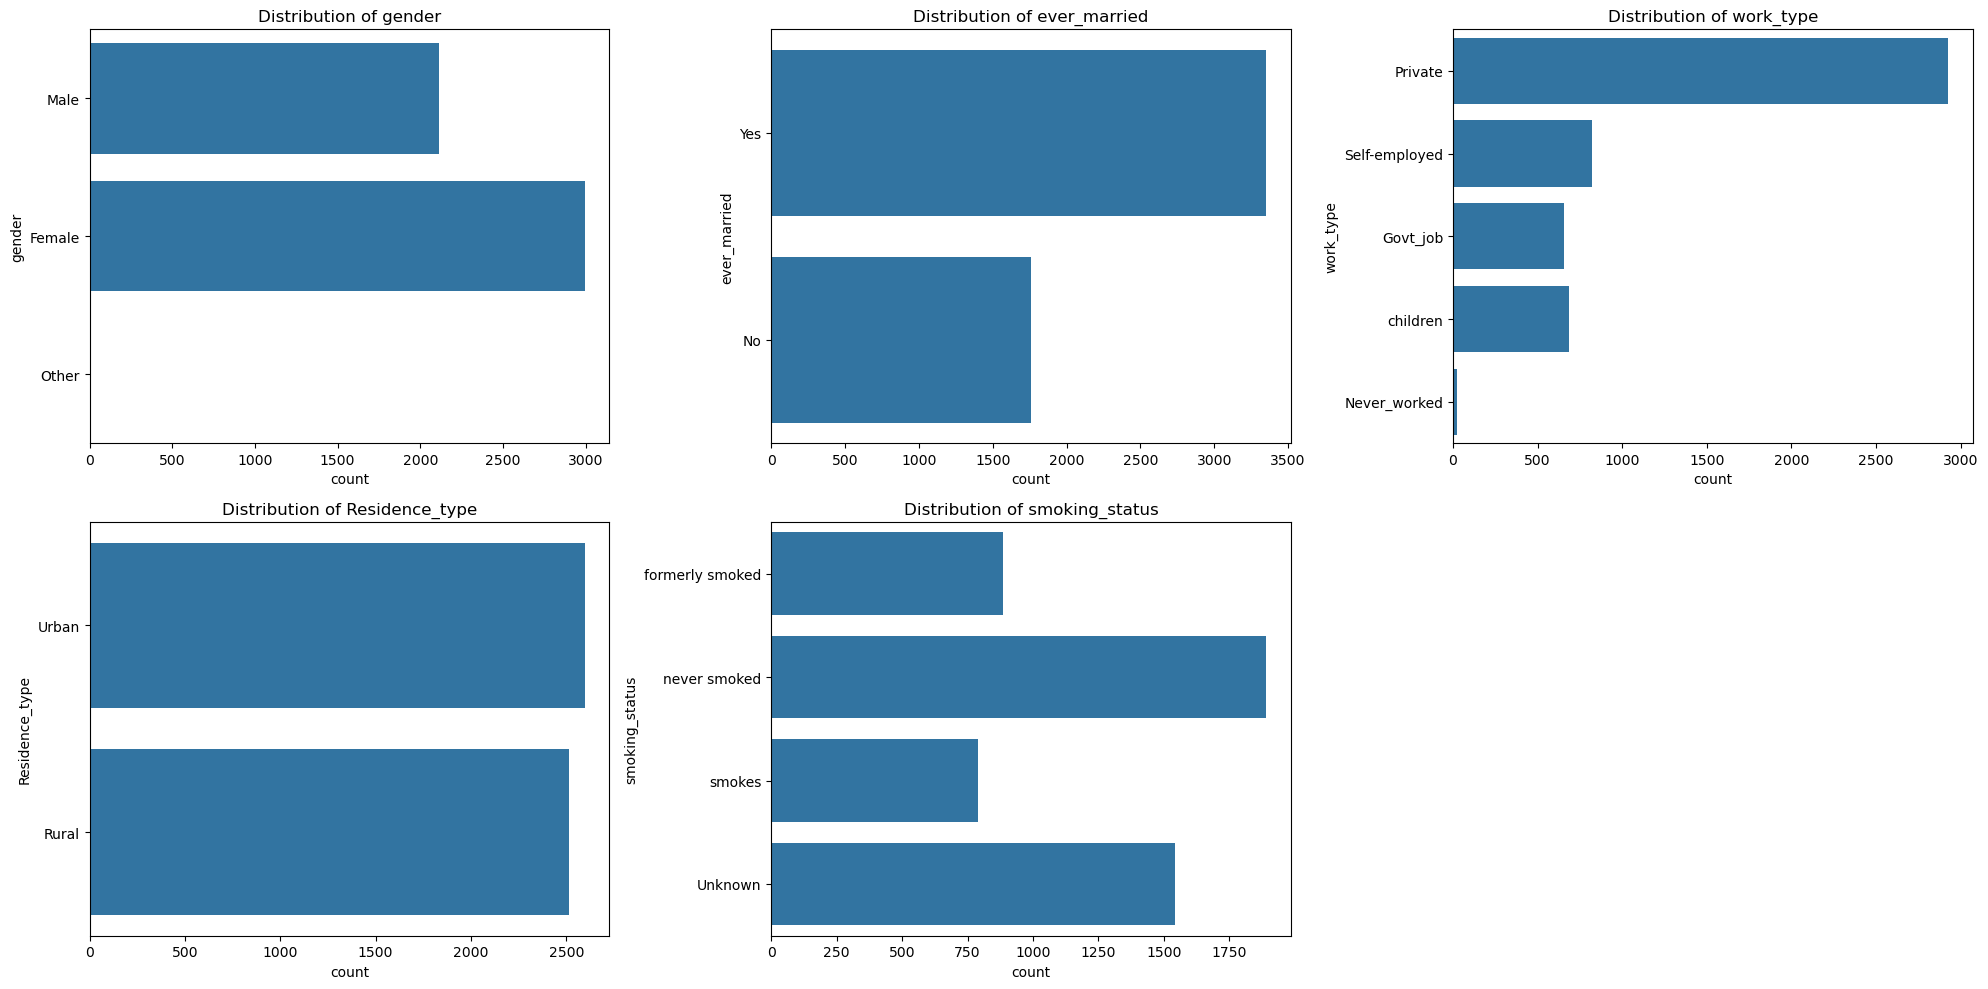

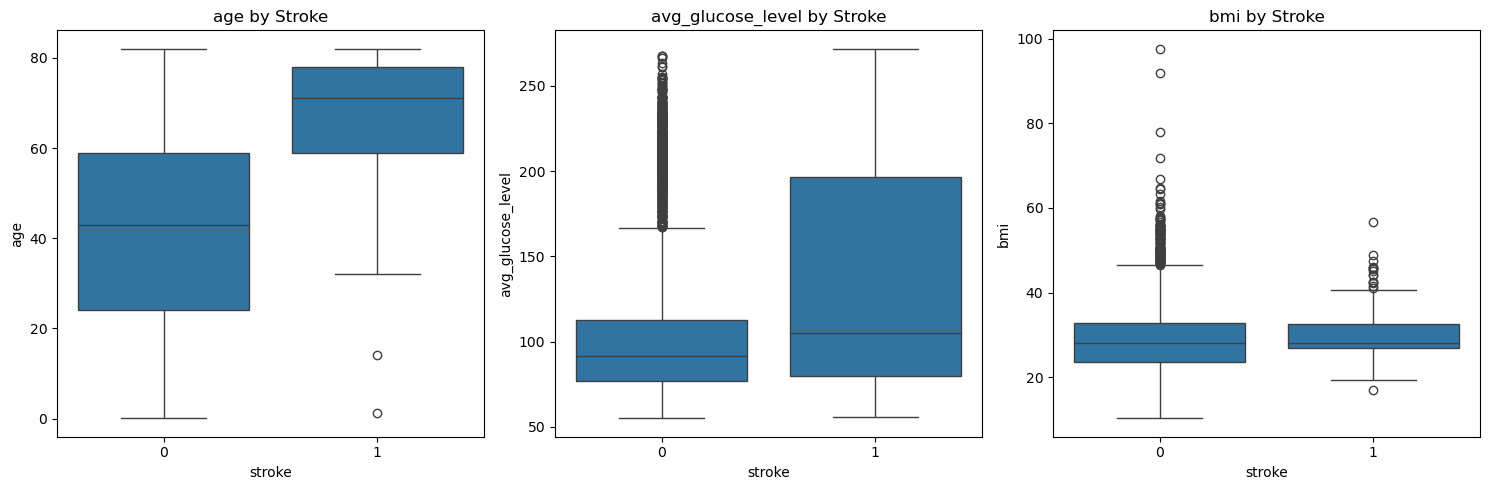

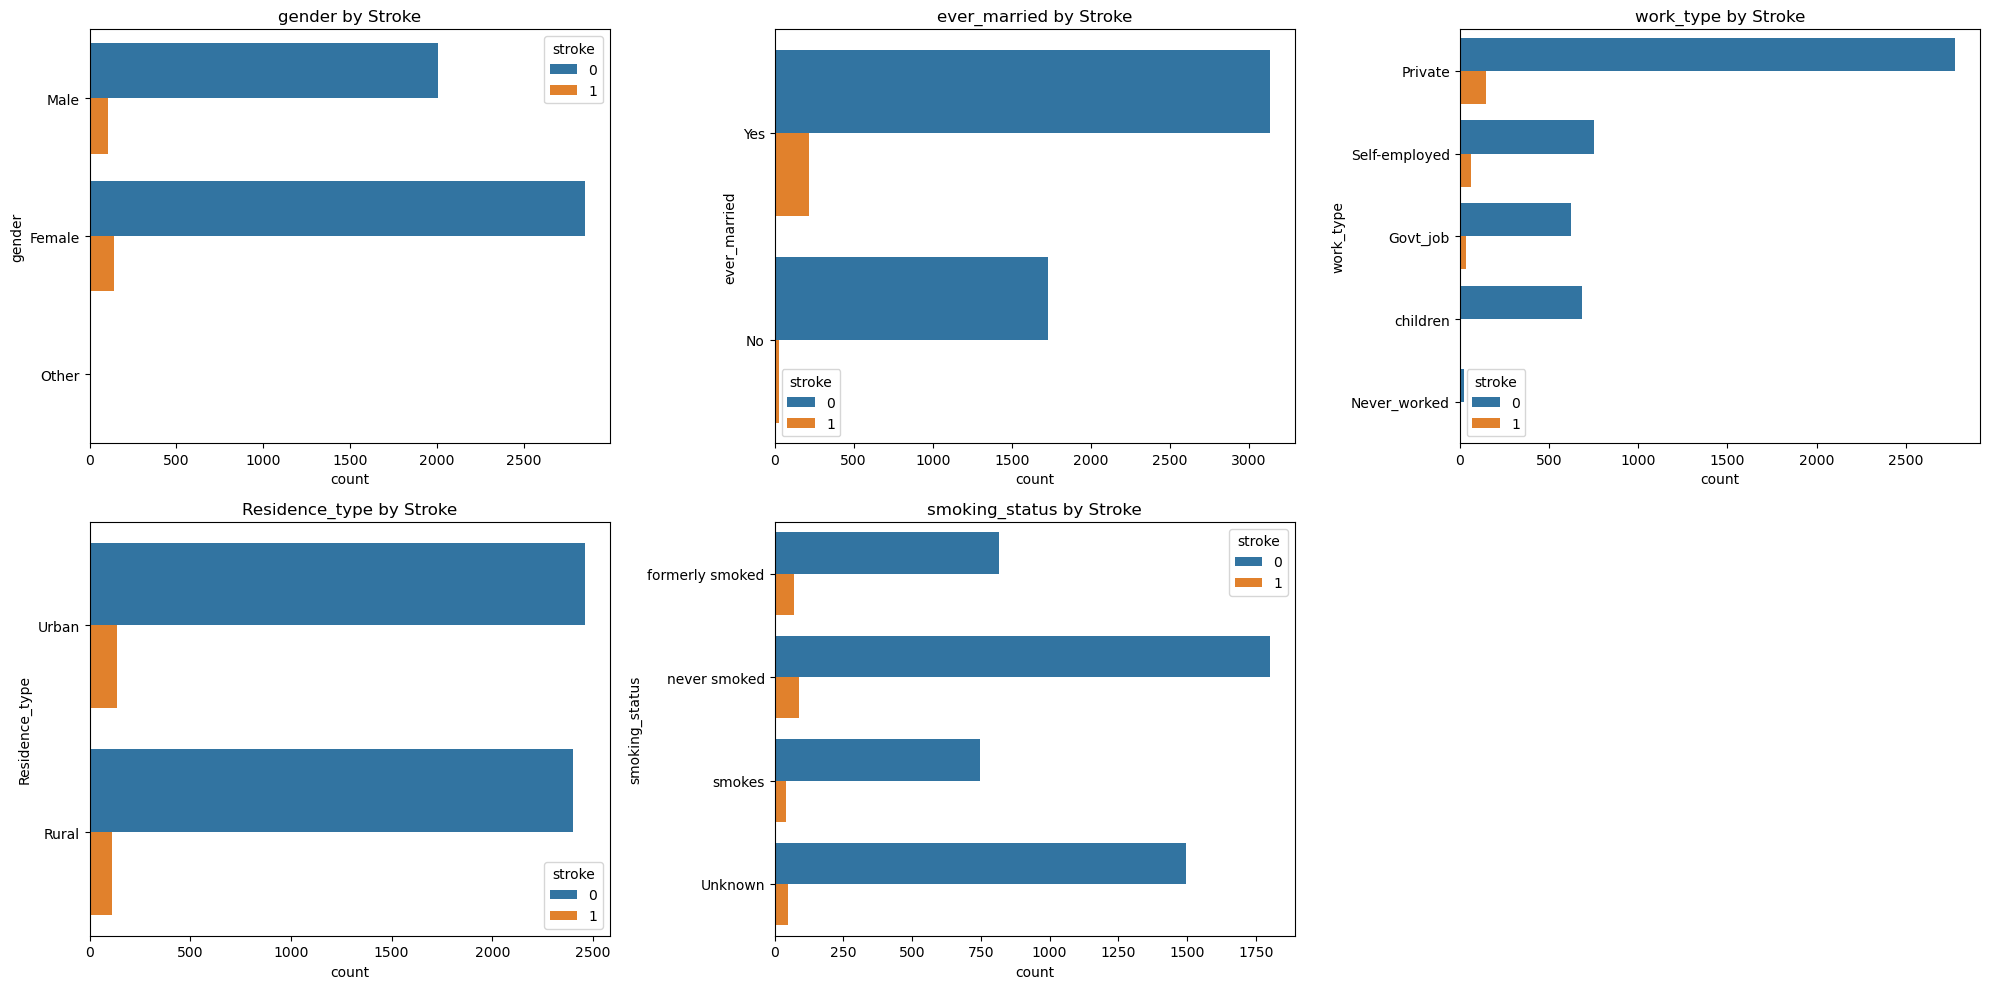

In [58]:
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Visualizing the relationship between different variables and stroke occurrence
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='stroke', y=feature, data=data)
    plt.title(f'{feature} by Stroke')
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=feature, hue='stroke', data=data)
    plt.title(f'{feature} by Stroke')
plt.tight_layout()
plt.show()


# Preparing  Features and Target Variable

In [59]:
X = data.drop(['stroke', 'id'], axis=1)
y = data['stroke']

# Preprocess Data

In [60]:
# Encoding categorical variables using OneHotEncoder
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)


# Split Data into Training and Test Sets

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Train and Evaluate Models

In [62]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Create and train models individually
trained_models = {}
for name, model in models.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline
    
    # Evaluate model performance
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    y_test_pred = pipeline.predict(X_test)
    
    print(f'\n{name} - Training Accuracy: {train_accuracy:.2f}')
    print(f'{name} - Test Accuracy: {test_accuracy:.2f}')
    print(f'{name} - Classification Report for Test Data:')
    print(classification_report(y_test, y_test_pred))
    print(f'{name} - Confusion Matrix for Test Data:')
    print(confusion_matrix(y_test, y_test_pred))
    print(f'{name} - ROC-AUC Score: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.2f}')


Logistic Regression - Training Accuracy: 0.74
Logistic Regression - Test Accuracy: 0.75
Logistic Regression - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.78      0.23        50

    accuracy                           0.75      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.75      0.82      1022

Logistic Regression - Confusion Matrix for Test Data:
[[726 246]
 [ 11  39]]
Logistic Regression - ROC-AUC Score: 0.84

Random Forest - Training Accuracy: 1.00
Random Forest - Test Accuracy: 0.91
Random Forest - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.09      0.10      0.09        50

    accuracy                           0.91      1022
   macro avg       0.52      0.52      0.52      1022
weig

In [63]:
# Train and evaluate the Random Forest model individually
rf_model = RandomForestClassifier(random_state=42)
rf_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                 ('smote', smote),
                                 ('classifier', rf_model)])
rf_pipeline.fit(X_train, y_train)

# Evaluate Random Forest model performance
rf_train_accuracy = rf_pipeline.score(X_train, y_train)
rf_test_accuracy = rf_pipeline.score(X_test, y_test)
rf_y_test_pred = rf_pipeline.predict(X_test)

print(f'\nRandom Forest - Training Accuracy: {rf_train_accuracy:.2f}')
print(f'Random Forest - Test Accuracy: {rf_test_accuracy:.2f}')
print('Random Forest - Classification Report for Test Data:')
print(classification_report(y_test, rf_y_test_pred))
print('Random Forest - Confusion Matrix for Test Data:')
print(confusion_matrix(y_test, rf_y_test_pred))
print(f'Random Forest - ROC-AUC Score: {roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1]):.2f}')


Random Forest - Training Accuracy: 1.00
Random Forest - Test Accuracy: 0.91
Random Forest - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.09      0.10      0.09        50

    accuracy                           0.91      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.91      0.91      0.91      1022

Random Forest - Confusion Matrix for Test Data:
[[921  51]
 [ 45   5]]
Random Forest - ROC-AUC Score: 0.76


# Creating Ensemble and its evalution 

In [64]:
# Create an ensemble model using Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)

# Train the ensemble model
ensemble_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('ensemble', ensemble_model)])
ensemble_pipeline.fit(X_train, y_train)

# Evaluate the ensemble model
ensemble_train_accuracy = ensemble_pipeline.score(X_train, y_train)
ensemble_test_accuracy = ensemble_pipeline.score(X_test, y_test)
ensemble_y_test_pred = ensemble_pipeline.predict(X_test)

print(f'\nEnsemble Model - Training Accuracy: {ensemble_train_accuracy:.2f}')
print(f'Ensemble Model - Test Accuracy: {ensemble_test_accuracy:.2f}')
print('Ensemble Model - Classification Report for Test Data:')
print(classification_report(y_test, ensemble_y_test_pred))
print('Ensemble Model - Confusion Matrix for Test Data:')
print(confusion_matrix(y_test, ensemble_y_test_pred))
print(f'Ensemble Model - ROC-AUC Score: {roc_auc_score(y_test, ensemble_pipeline.predict_proba(X_test)[:, 1]):.2f}')



Ensemble Model - Training Accuracy: 0.92
Ensemble Model - Test Accuracy: 0.86
Ensemble Model - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.18      0.56      0.27        50

    accuracy                           0.86      1022
   macro avg       0.58      0.72      0.60      1022
weighted avg       0.94      0.86      0.89      1022

Ensemble Model - Confusion Matrix for Test Data:
[[846 126]
 [ 22  28]]
Ensemble Model - ROC-AUC Score: 0.82


# Predict Using Ensemble Model

In [65]:
# Predicting using the ensemble model (for demonstration)
sample_data = X_test.sample(n=1, random_state=42)
predictions = ensemble_pipeline.predict(sample_data)

print("\nPredictions for Random Sample Data:")
print(predictions)



Predictions for Random Sample Data:
[0]


In [66]:
sample_data = X_test.sample(n=1, random_state=42)
predictions = ensemble_pipeline.predict(sample_data)

prediction_labels = {0: 'No Stroke', 1: 'Stroke'}
predicted_label = prediction_labels[predictions[0]]

print("\nPredictions for Random Sample Data:")
print(f"Predicted: {predicted_label}")


Predictions for Random Sample Data:
Predicted: No Stroke


In [67]:
#new data dictionary for testing // Positive Example
new_data_dict_test = {
    'age': 65,  
    'avg_glucose_level': 220.0,  # Higher glucose level
    'bmi': 40.0,  # Higher BMI
    'gender': 'Male',
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'smoking_status': 'smokes'
}

new_data_df_test = pd.DataFrame([new_data_dict_test])
prediction_test = ensemble_pipeline.predict(new_data_df_test)
prediction_labels = {0: 'No Stroke', 1: 'Stroke'}


print("Prediction for New Sample Data (Test Case):")
print(f"Predicted: {prediction_labels[prediction_test[0]]}")


Prediction for New Sample Data (Test Case):
Predicted: Stroke


In [68]:
# Stroke Negative Example
new_data_dict_test = {
    'age': 20,  
    'avg_glucose_level': 220.0,  # Higher glucose level
    'bmi': 25.0,  # Lower BMI
    'gender': 'Male',
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'smoking_status': 'never smoked'
}

new_data_df_test = pd.DataFrame([new_data_dict_test])
prediction_test = ensemble_pipeline.predict(new_data_df_test)
prediction_labels = {0: 'No Stroke', 1: 'Stroke'}

print("Prediction for New Sample Data (Test Case):")
print(f"Predicted: {prediction_labels[prediction_test[0]]}")


Prediction for New Sample Data (Test Case):
Predicted: No Stroke


# Prediction Usign Trained Randorm Forest Model

In [70]:
new_data_dict_test = {
    'age': 65,  # Older age
    'avg_glucose_level': 220.0,  # Higher glucose level
    'bmi': 40.0,  # Higher BMI
    'gender': 'Male',
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'smoking_status': 'smokes'
}


new_data_df_test = pd.DataFrame([new_data_dict_test])
prediction_test = rf_pipeline.predict(new_data_df_test)
prediction_labels = {0: 'No Stroke', 1: 'Stroke'}

print("Prediction for Sample Data (Test Case):")
print(f"Predicted: {prediction_labels[prediction_test[0]]}")


Prediction for Sample Data (Test Case):
Predicted: Stroke
